In [ ]:
# localization.ipynb
!pip install ultralytics opencv-python matplotlib

In [18]:

import cv2
import numpy as np
import matplotlib.pyplot as plt
from ultralytics import YOLO
from tensorflow.keras.models import load_model
from PIL import Image

In [19]:
# Load YOLO model
yolo_model = YOLO('yolo11m.pt')

In [20]:

# Load the kidney stone classification model
classification_model = load_model('../kidney_stone_detection_model.h5')

In [21]:
# Preprocessing for YOLO
def preprocess_image_yolo(image_path):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

In [22]:
# Preprocessing for the classification model
def preprocess_image_classification(image_path, target_size=(150, 150)):
    img = Image.open(image_path).convert('RGB')
    img = img.resize(target_size)
    img = np.array(img) / 255.0
    img = np.expand_dims(img, axis=0)
    return img

In [41]:
# Perform localization
def detect_and_localize(image_path):
    # Step 1: Use classification model for binary classification
    preprocessed_image = preprocess_image_classification(image_path)
    prediction = classification_model.predict(preprocessed_image)
    predicted_class = np.argmax(prediction, axis=-1)

    if predicted_class[0] == 0:
        print("Prediction: Normal (No stone detected)")
        return None

    print("Prediction: Stone Detected")

    # Step 2: Use YOLO for localization
    img = preprocess_image_yolo(image_path)
    results = yolo_model.predict(img, conf=0.1)  # Adjust confidence threshold as needed

    # Create a copy of the image for highlighting
    highlighted_image = img.copy()

    for result in results:
        for box in result.boxes:
            # Get bounding box coordinates and confidence score
            x1, y1, x2, y2 = box.xyxy.numpy().astype(int).flatten()
            confidence = box.conf.numpy().item()

            # Highlight the detected area by drawing a border
            highlighted_image = cv2.rectangle(
                highlighted_image, (x1, y1), (x2, y2), (255, 0, 0), 5
            )
            cv2.putText(
                highlighted_image, f"Stone: {confidence:.2f}", (x1, y1 - 10),
                cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 255, 255), 2
            )

    # Display the highlighted image
    plt.figure(figsize=(12, 8))
    plt.imshow(highlighted_image)
    plt.axis("off")
    plt.show()

    return highlighted_image

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
Prediction: Stone Detected

0: 640x640 1 bowl, 2 oranges, 533.9ms
Speed: 3.0ms preprocess, 533.9ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)


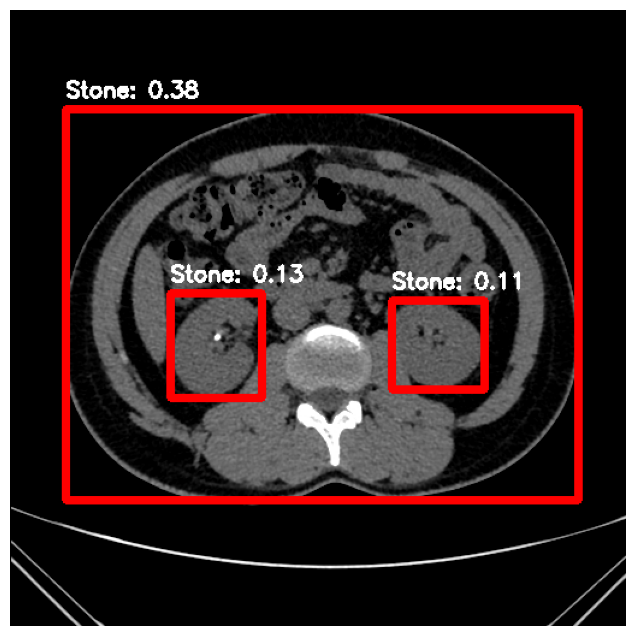

In [50]:
# Test with an image
test_image_path = "../dataset/test/Stone/Stone- (1002).jpg"
localized_image = detect_and_localize(test_image_path)


In [32]:

if localized_image is not None:
    output_path = "localized_output.jpg"
    cv2.imwrite(output_path, cv2.cvtColor(localized_image, cv2.COLOR_RGB2BGR))
    print(f"Localized image saved to {output_path}")

Localized image saved to localized_output.jpg
